<a href="https://colab.research.google.com/github/mohamedsayed18/Pose_estimation/blob/master/TFlite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import cv2 
from matplotlib import pyplot as plt

In [2]:
#load my drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [37]:
# Load the image
img = cv2.imread("/content/drive/My Drive/innopolis/1st year courses/2nd term/CV/GP/data/human.jpg")
new_im = cv2.resize(img, (257,257)).reshape((1, 257, 257, 3))
new_im = new_im.astype(np.float32)
print(new_im.shape)

(1, 257, 257, 3)


In [0]:
# Load TFLite model and allocate tensors.
path = "/content/drive/My Drive/innopolis/1st year courses/2nd term/CV/GP/posenet.tflite"
interpreter = tf.lite.Interpreter(model_path=path)
interpreter.allocate_tensors()

In [0]:
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [0]:
# Test model on random input data.
#input_shape = input_details[0]['shape']   # get the shape
input_index = interpreter.get_input_details()[0]['index']   # get the index
#new_im = new_im.reshape((input_shape))  #reshape
#x = np.asarray(new_im).astype(np.float32)   # convert to float32


interpreter.set_tensor(input_index, new_im)
interpreter.invoke()

In [41]:
# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
output_offset = interpreter.get_tensor(output_details[1]['index'])
output_data = output_data[0]
output_offset = output_offset[0]
print(output_data.shape)
print(output_offset.shape)


(9, 9, 17)
(9, 9, 34)


In [0]:
# sigmoid function
def sigmoid(a):
  return 1/(1 + np.exp(-a))
# Reference
# https://www.geeksforgeeks.org/implement-sigmoid-function-using-numpy/

In [0]:
def get_keypoints(heatmaps, offsets, output_stride=8):
        scores = sigmoid(heatmaps) # step1: sigmoid
        num_keypoints = scores.shape[2]   # 17
        heatmap_positions = []
        offset_vectors = []
        confidences = []
        for k in range(num_keypoints ): # loop all the keypoints
            x,y = np.unravel_index(np.argmax(scores[:,:,k]), scores[:,:,k].shape) # get the x,y position
            confidences.append(scores[x,y,k])
            print(scores[x,y,k])
            offset_vector = (offsets[y,x,k], offsets[y,x,num_keypoints+k])  # the offset_vector
            heatmap_positions.append((x,y))   # store the indicies of the max
            offset_vectors.append(offset_vector)
        image_positions = np.add(np.array(heatmap_positions) * output_stride, offset_vectors)
        keypoints = [KeyPoint(i, pos, confidences[i]) for i, pos in enumerate(image_positions)]
        return keypoints

In [0]:
PARTS = {
    0: 'NOSE',
    1: 'LEFT_EYE',
    2: 'RIGHT_EYE',
    3: 'LEFT_EAR',
    4: 'RIGHT_EAR',
    5: 'LEFT_SHOULDER',
    6: 'RIGHT_SHOULDER',
    7: 'LEFT_ELBOW',
    8: 'RIGHT_ELBOW',
    9: 'LEFT_WRIST',
    10: 'RIGHT_WRIST',
    11: 'LEFT_HIP',
    12: 'RIGHT_HIP',
    13: 'LEFT_KNEE',
    14: 'RIGHT_KNEE',
    15: 'LEFT_ANKLE',
    16: 'RIGHT_ANKLE'
}

In [0]:
class KeyPoint():
    def __init__(self, index, pos, v):
        x, y = pos
        self.x = x
        self.y = y
        self.index = index
        self.body_part = PARTS.get(index)
        self.confidence = v

    def point(self):
        return int(self.y), int(self.x)

    def to_string(self):
        return 'part: {} location: {} confidence: {}'.format(
            self.body_part, (self.x, self.y), self.confidence)

In [55]:
keypoints = get_keypoints(output_data, output_offset)

0.005571248
0.008315361
0.0220139
0.05941798
0.018933624
0.22073653
0.047164094
0.09677105
0.060331803
0.008820234
0.017026225
0.021248786
0.015841786
0.020730497
0.0044449703
0.0033449281
0.004523641


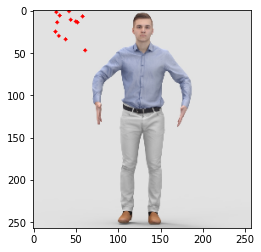

In [56]:
# Draw points on the image 
#print(img.shape)
draw_on = cv2.resize(img, (257,257))
#print(draw_on.shape)
draw = cv2.cvtColor(draw_on, cv2.COLOR_BGR2RGB)

for i in keypoints:
  center = i.point()
  cv2.circle(draw, center, 2, (255,0,0), -1)

plt.imshow(draw)
#Reference
#cv.Circle(img, center, radius, color, thickness=1, lineType=8, shift=0)